In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
%matplotlib widget

import importlib
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import ExperimentClass
import tools
import math_functions as mf


In [2]:
importlib.reload(ExperimentClass)
importlib.reload(tools)
importlib.reload(mf)

<module 'math_functions' from 'c:\\Users\\Orlando\\Desktop\\DREAM_repo\\math_functions.py'>

In [3]:
manip = ExperimentClass.Experiment("20241127_activation_Pt1-1","PSI", DataType=".csv", sep = ';')
#Intensities = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 100]
#Intensities = [0, 26.9, 93.1, 157.4, 232.5, 365.5, 591.3]
Intensities = [0, 26.9, 58.8, 93.1, 157.4, 232.5, 304.2, 365.5, 520.2, 661.1]
condition = "Pt1 - 1"

C:\Users\Orlando\AppData\Local\Temp\ipykernel_23912\3222298064.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('inferno', len(act))


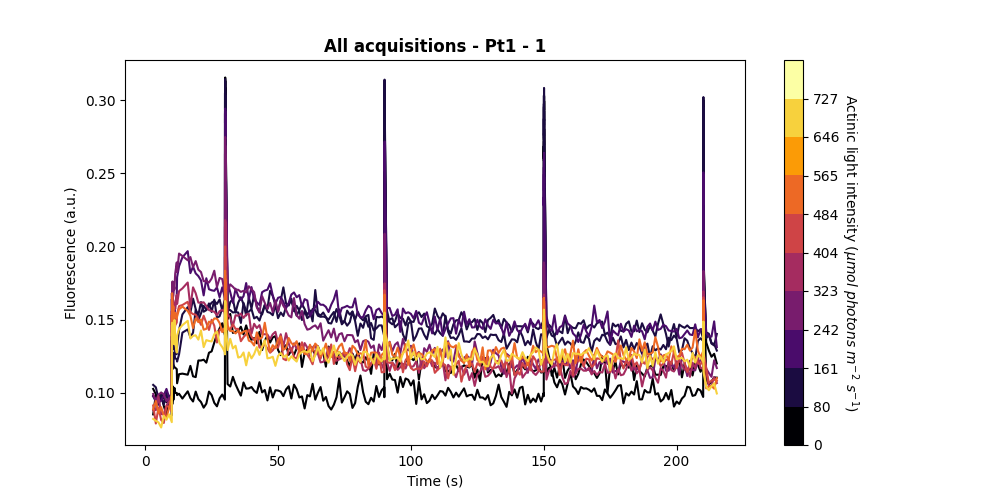

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
act = np.linspace(0, max(Intensities)*1.1, 10)
cmap = plt.cm.get_cmap('inferno', len(act))
for i, k in enumerate(manip.records[::-1]):
    ax.plot(manip.Time, manip.Data[k], color = cmap(tools.closest_index(act,Intensities[i])), label = f"{Intensities[i]}%")

cmap_legend = True
if cmap_legend:
# add cmap legend
    sm = ScalarMappable(norm=colors.Normalize(vmin=0, vmax=len(act)), cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=range(len(act)), ax = ax)
    cbar.ax.set_yticklabels([f'{int(label)}' for label in act])
    cbar.ax.set_ylabel('Actinic light intensity ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)', rotation=270, labelpad=15)
else:
    ax.legend(title = "Actinic light intensity", loc = 'upper left', borderaxespad = 3)
    fig.set_figwidth(10)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Fluorescence (a.u.)')
ax.set_title(f'All acquisitions - {condition}', fontweight = 'bold')

fig.savefig(f"{manip.fig_folder}/All_acquisitions.png", dpi=300)


Text(0, 0.5, 'Fluorescence (a.u.)')

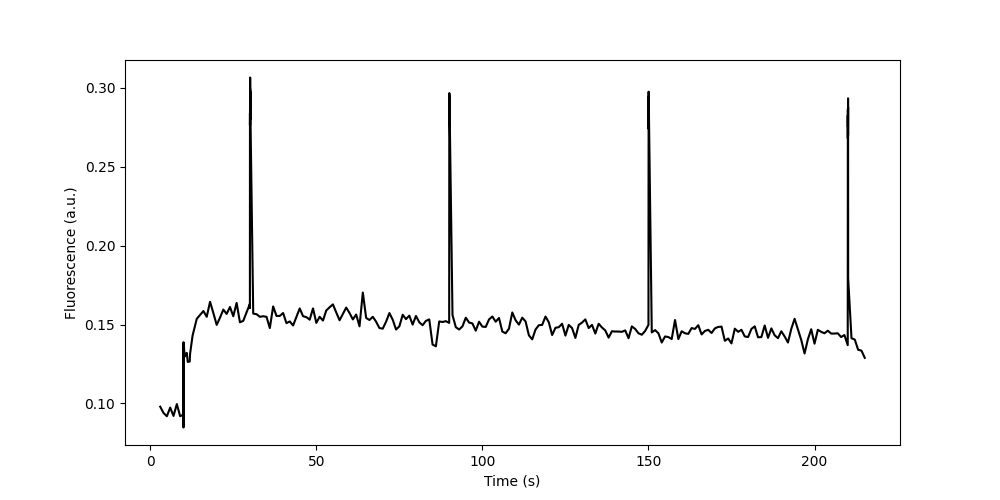

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(manip.Time, manip.Data["AL20"], color = 'k')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Fluorescence (a.u.)')


In [12]:
def compute_params(Experiment_df, Intensities, times_Fmax ):
    
    t_F0 = [0, 9]                  # time interval for F0 calculation in seconds
    t_Fstat = [-6, -0.5]              # time interval for Fstat calculation in seconds RELATIVE TO F_MAX!!!
    t_Fmax = [0.1, 0.12]       # time interval for Fmax_OJ calculation in seconds RELATIVE TO F_MAX!!!
    
    F_max = []
    F_stat = []
    F_0 = []
    phi_stat = []
    phi_0 = []
    NPQ = []
    ETR = []

    for i, k in enumerate(Experiment_df.records[::-1]):
        F_0.append(np.mean(Experiment_df.Data[k][np.where(Experiment_df.Time>= t_F0[0])[0][0] :np.where(Experiment_df.Time>= t_F0[1])[0][0]]))
        aux_F_max = []
        aux_F_stat = []
        aux_phi_stat = []
        aux_ETR = []
        aux_NPQ = []        
        for j, t in enumerate(times_Fmax):
            aux_F_max.append(np.mean(Experiment_df.Data[k][np.where(Experiment_df.Time>= t_Fmax[0] + t)[0][0] :np.where(Experiment_df.Time>= t_Fmax[1] + t)[0][0]]))
            aux_F_stat.append(np.mean(Experiment_df.Data[k][np.where(Experiment_df.Time>= t_Fstat[0] + t)[0][0] :np.where(Experiment_df.Time>= t_Fstat[1] + t)[0][0]]))
            aux_phi_stat.append((aux_F_max[j] - aux_F_stat[j]) / aux_F_max[j])
            aux_ETR.append(aux_phi_stat[j] * Intensities[i])
            if i == 0:
                aux_NPQ.append((aux_F_max[0] - aux_F_max[j])/aux_F_max[j])
            else:
                aux_NPQ.append((F_max[0][0] - aux_F_max[j])/aux_F_max[j])
        F_max.append(list(aux_F_max))
        F_stat.append(list(aux_F_stat))
        phi_stat.append(aux_phi_stat)
        ETR.append(aux_ETR)
        NPQ.append(aux_NPQ)

        phi_0.append((F_max[i][0] - F_0[i]) / F_max[i][0])
        
    norm = F_max[0][0]
    
    F_max = list(np.array(F_max)/norm)
    F_stat = list(np.array(F_stat)/norm)
    F_0 = list(np.array(F_0)/norm)
        
    params_df = pd.DataFrame({'Record': Experiment_df.records[::-1], 'Actinic': Intensities, 'F_max': F_max, 'F_stat': F_stat,
                              'F_0': F_0, 'phi_stat': phi_stat, 'phi_0': phi_0, 'NPQ': NPQ, 'ETR': ETR})
    
    return params_df, norm
    

In [13]:
times_Fmax = [30, 90, 150, 210]
params_df, norm = compute_params(manip, Intensities, times_Fmax)
params_df.to_csv(f"{manip.path}/params.csv", sep = ';', index = False)

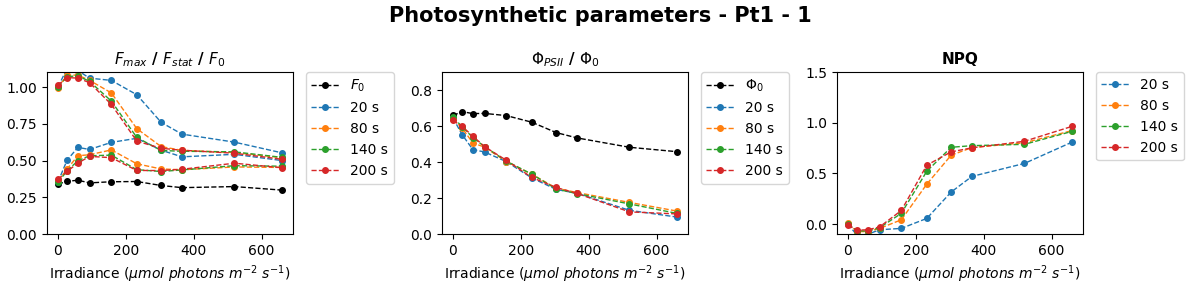

In [14]:
fig, ax = plt.subplots(1,3, figsize = (12,3))
fig.suptitle(f"Photosynthetic parameters - {condition}", fontsize = 15, fontweight = 'bold')
line = 1
marker = 4

ax[0].plot(params_df.Actinic, params_df.F_0, 'o--', markersize = marker, linewidth = line, color = 'k', label = '$F_{0}$')
ax[1].plot(params_df.Actinic, params_df.phi_0, 'o--', markersize = marker, linewidth = line, color = 'k', label = '$Φ_{0}$')
ax[0].set_title('$F_{max}$ / $F_{stat}$ / $F_{0}$', fontsize = 11, fontweight = 'bold')
ax[1].set_title('$Φ_{PSII}$ / $Φ_{0}$', fontsize = 11, fontweight = 'bold')
ax[2].set_title('NPQ', fontsize = 11, fontweight = 'bold')
ax = ax.flatten() 
[ax.set_xlabel("Irradiance ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)", fontsize = 10) for ax in ax]

ax[0].set_ylim(0, 1.1)
ax[1].set_ylim(0, 0.9)
ax[2].set_ylim(-0.1, 1.5)


for i in range(len(times_Fmax)):
    ax[0].plot(params_df.Actinic, np.asarray(params_df.F_max.tolist())[:,i], 'o--', markersize = marker, linewidth = line, color = f"C{i}", label = f"{times_Fmax[i]-10} s")
    ax[0].plot(params_df.Actinic, np.asarray(params_df.F_stat.tolist())[:,i], 'o--', markersize = marker, linewidth = line, color = f"C{i}")
    ax[1].plot(params_df.Actinic, np.asarray(params_df.phi_stat.tolist())[:,i], 'o--', markersize = marker, linewidth = line, label = f"{times_Fmax[i]-10} s", color = f"C{i}")
    ax[2].plot(params_df.Actinic, np.asarray(params_df.NPQ.tolist())[:,i], 'o--', markersize = marker, linewidth = line, label = f"{times_Fmax[i]-10} s", color = f"C{i}")

[ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) for ax in ax]
fig.tight_layout()

fig.savefig(f"{manip.fig_folder}/Parameters.png", dpi=300)

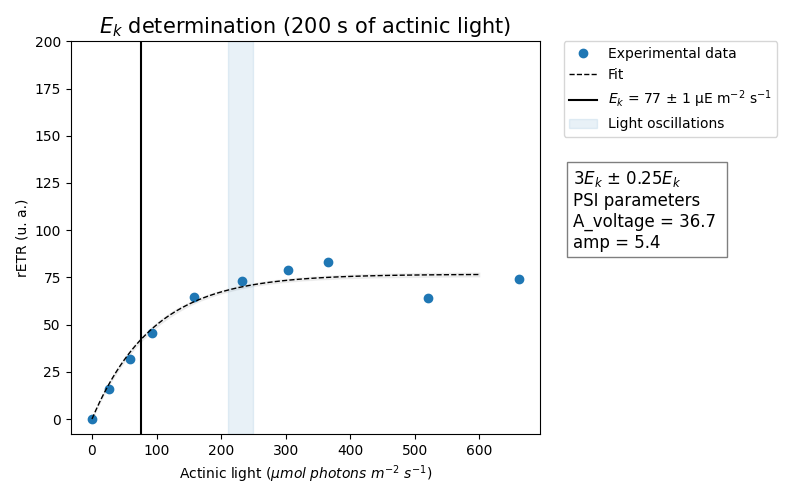

In [15]:
offset_Ek = 3
amp_EK = 0.25

light = params_df.Actinic.tolist()
ETR_matrix = np.asarray(params_df.ETR.tolist())

time_Fmax = 200

fig, ax = plt.subplots(figsize = (8,5))
ax.set_title(f"$E_k$ determination ({time_Fmax} s of actinic light)", fontsize = 15)


i = times_Fmax.index(time_Fmax + 10)

ETR = ETR_matrix[:,i]
ax.plot(light, ETR, 'o', label = "Experimental data")

popt, pcov, xfit, yfit = tools.Ek_fit(light, ETR, 0, 600, 100, p0 = [100, 100])
err = tools.my_err(xfit, popt, pcov, mf.Ek)
ax.fill_between(xfit, yfit - 1.94*err, yfit + 1.94*err, alpha=0.05, color = "k")
ax.plot(xfit, yfit, '--', color ="k", linewidth = 1, label = "Fit")
Ek = popt[0]
Ek_err = np.sqrt(np.diag(pcov))[0]

ax.axvline(x=Ek, linewidth=1.5, label = f"$E_k$ = {Ek:.0f} ± {Ek_err:.0f} µE m$^{{-2}}$ s$^{{-1}}$", color = 'k')
ax.set_xlabel("Actinic light ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)")
ax.set_ylabel("rETR (u. a.)")
AL_min = tools.get_AL(offset_Ek*Ek - amp_EK*Ek)
AL_max = tools.get_AL(offset_Ek*Ek + amp_EK*Ek)
AL_amp = AL_max - AL_min

ax.text(1.07, 0.57, f"{offset_Ek}$E_k$ ± {amp_EK}$E_k$ \nPSI parameters \nA_voltage = {AL_min:.1f} \namp = {AL_amp:.1f}", fontsize=12, verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

ax.fill_betweenx([-8, 200], offset_Ek*Ek - amp_EK*Ek, offset_Ek*Ek + amp_EK*Ek, alpha=0.1, color = "C0", label = "Light oscillations")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax.set_ylim(-8, 200)

fig.tight_layout()
fig.savefig(f"{manip.fig_folder}/Ek_bode.png", dpi=300)

In [16]:
manip.name

'20241127_activation_Pt1-1'

C:\Users\Orlando\AppData\Local\Temp\ipykernel_23912\1984581312.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('inferno', len(act))


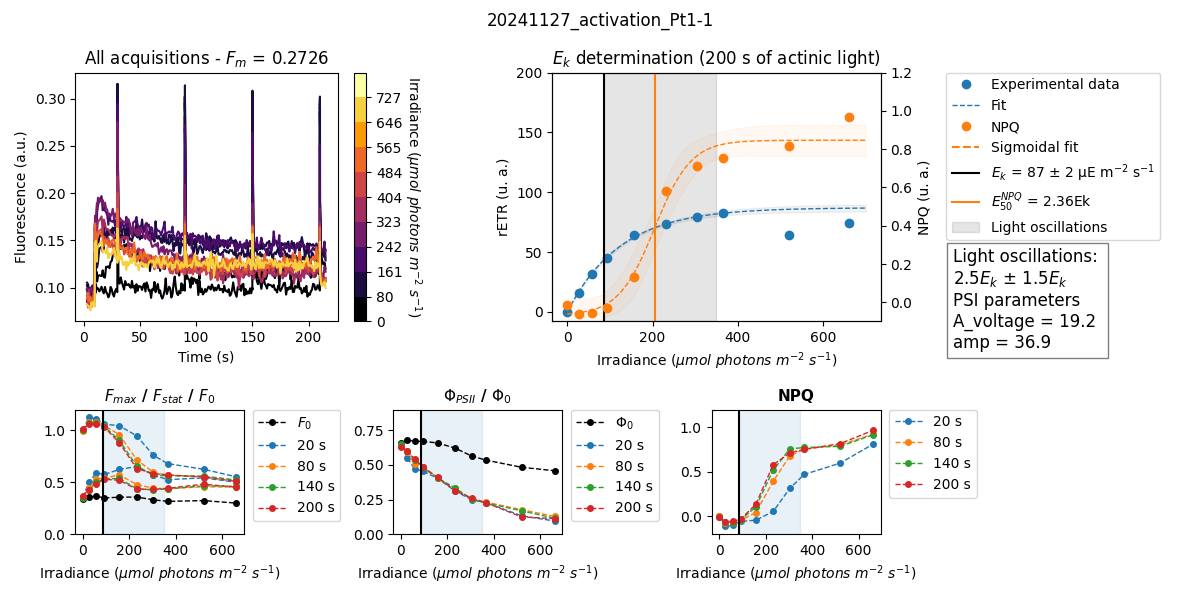

In [22]:
offset_Ek = 2.5
amp_EK = 1.5

NPQ_ax_lim = 1.2
ETR_ax_lim = 200



import matplotlib.gridspec as gridspec

# Create a grid with 2 rows, adjusting to have 2 plots in the first row and 3 plots in the second row
fig = plt.figure(figsize=(12, 6))
fig.suptitle(manip.name)
gs = gridspec.GridSpec(2, 6, height_ratios=[1, 0.5])

# First plot (will span the first two columns of the first row)
ax1 = fig.add_subplot(gs[0, 0:3])  # Span 4/6 columns in the first row
act = np.linspace(0, max(Intensities)*1.1, 10)
cmap = plt.cm.get_cmap('inferno', len(act))
for i, k in enumerate(manip.records[::-1]):
    ax1.plot(manip.Time, manip.Data[k], color=cmap(tools.closest_index(act, Intensities[i])), label=f"{Intensities[i]}%")

# Add color map legend for first plot
cmap_legend = True
if cmap_legend:
    sm = ScalarMappable(norm=colors.Normalize(vmin=0, vmax=len(act)), cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=range(len(act)), ax=ax1)
    cbar.ax.set_yticklabels([f'{int(label)}' for label in act])
    cbar.ax.set_ylabel('Irradiance ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)', rotation=270, labelpad=15)
else:
    ax1.legend(title="Actinic light intensity", loc='upper left', borderaxespad=3)

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Fluorescence (a.u.)')
ax1.set_title(f'All acquisitions - $F_m$ = {norm:.4f}')

# Third plot (placed in the third column of the first row)
ax2 = fig.add_subplot(gs[0, 3:])  #
light = params_df.Actinic.tolist()
ETR_matrix = np.asarray(params_df.ETR.tolist())
time_Fmax = 200
i = times_Fmax.index(time_Fmax + 10)

ETR = ETR_matrix[:, i]
ax2.plot(light, ETR, 'o', label="Experimental data")

popt, pcov, xfit, yfit = tools.Ek_fit(light[:7], ETR[:7], 0, 700, 100, p0=[100, 100])
err = tools.my_err(xfit, popt, pcov, mf.Ek)
ax2.fill_between(xfit, yfit - 1.94 * err, yfit + 1.94 * err, alpha=0.05, color="k")
ax2.plot(xfit, yfit, '--', color="C0", linewidth=1, label="Fit")
Ek = popt[0]
Ek_err = np.sqrt(np.diag(pcov))[0]

ax2.plot([], [], 'o', label = f"NPQ", color = 'C1')
ax2.plot([], [], '--', label = "Sigmoidal fit", color = 'C1')

ax2.axvline(x=Ek, linewidth=1.5, label=f"$E_k$ = {Ek:.0f} ± {Ek_err:.0f} µE m$^{{-2}}$ s$^{{-1}}$", color='k')

AL_min = tools.get_AL(offset_Ek*Ek - amp_EK*Ek)
AL_max = tools.get_AL(offset_Ek*Ek + amp_EK*Ek)
AL_amp = AL_max - AL_min

ax2_bis = ax2.twinx()
ax2_bis.plot(params_df.Actinic, np.asarray(params_df.NPQ.tolist())[:,i], 'o', label = f"NPQ", color = 'C1')
ax2_bis.set_ylabel("NPQ (u. a.)")

popt, pcov, xfit, yfit = tools.sigmoid_fit(light, np.asarray(params_df.NPQ.tolist())[:,i], 0, 700, 100, p0 =  [1, 0.02, 300, 0])
err = tools.my_err(xfit, popt, pcov, mf.sigmoid)
ax2_bis.fill_between(xfit, yfit - 1.94*err, yfit + 1.94*err, alpha=0.05, color = "C1")
ax2_bis.plot(xfit, yfit, '--', linewidth = 1, label = "Fit", color = 'C1')
ax2_bis.axvline(x=popt[2], linewidth=1.5, color = 'C1')
ax2_bis.set_ylim(-0.1, NPQ_ax_lim)

ax2.plot([], [], '-', label = "$E_{50}^{NPQ}$ = " + f"{popt[2]/Ek:.2f}Ek", color = 'C1')


ax2.set_xlabel("Irradiance ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)")
ax2.set_ylabel("rETR (u. a.)")
ax2.set_ylim(-8, ETR_ax_lim)
ax2.set_title(f"$E_k$ determination ({time_Fmax} s of actinic light)")
ax2.text(1.22, 0.085, f"Light oscillations: \n{offset_Ek}$E_k$ ± {amp_EK}$E_k$ \nPSI parameters \nA_voltage = {AL_min:.1f} \namp = {AL_amp:.1f}", fontsize=12, verticalalignment='center', transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.5))

ylim = ax2.get_ylim()
ax2.fill_betweenx([ylim[0], ylim[1]], offset_Ek*Ek - amp_EK*Ek, offset_Ek*Ek + amp_EK*Ek, alpha=0.1, color = "k", label = "Light oscillations")
ax2.set_ylim(ylim)
ax2.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0.)


# Second plot (3 subplots in the second row)
ax3 = fig.add_subplot(gs[1, 0:2])  # First column of second row
ax4 = fig.add_subplot(gs[1, 2:4])  # Second column of second row
ax5 = fig.add_subplot(gs[1, 4:])  # Third column of second row

line = 1
marker = 4

ax3.plot(params_df.Actinic, params_df.F_0, 'o--', markersize=marker, linewidth=line, color='k', label='$F_{0}$')
ax4.plot(params_df.Actinic, params_df.phi_0, 'o--', markersize=marker, linewidth=line, color='k', label='$Φ_{0}$')


for i in range(len(times_Fmax)):
    ax3.plot(params_df.Actinic, np.asarray(params_df.F_max.tolist())[:,i], 'o--', markersize = marker, linewidth = line, color = f"C{i}", label = f"{times_Fmax[i]-10} s")
    ax3.plot(params_df.Actinic, np.asarray(params_df.F_stat.tolist())[:,i], 'o--', markersize = marker, linewidth = line, color = f"C{i}")
    ax4.plot(params_df.Actinic, np.asarray(params_df.phi_stat.tolist())[:,i], 'o--', markersize = marker, linewidth = line, label = f"{times_Fmax[i]-10} s", color = f"C{i}")
    ax5.plot(params_df.Actinic, np.asarray(params_df.NPQ.tolist())[:,i], 'o--', markersize = marker, linewidth = line, label = f"{times_Fmax[i]-10} s", color = f"C{i}")

ax3.fill_betweenx([0, 1.2], offset_Ek*Ek - amp_EK*Ek, offset_Ek*Ek + amp_EK*Ek, alpha=0.1, color = "C0")
ax3.axvline(x=Ek, linewidth=1.5, color = 'k')
ax4.fill_betweenx([0, 0.9], offset_Ek*Ek - amp_EK*Ek, offset_Ek*Ek + amp_EK*Ek, alpha=0.1, color = "C0")
ax4.axvline(x=Ek, linewidth=1.5, color = 'k')
ax5.fill_betweenx([-0.2, NPQ_ax_lim], offset_Ek*Ek - amp_EK*Ek, offset_Ek*Ek + amp_EK*Ek, alpha=0.1, color = "C0")
ax5.axvline(x=Ek, linewidth=1.5, color = 'k')


ax3.set_title('$F_{max}$ / $F_{stat}$ / $F_{0}$', fontsize=11, fontweight='bold')
ax4.set_title('$Φ_{PSII}$ / $Φ_{0}$', fontsize=11, fontweight='bold')
ax5.set_title('NPQ', fontsize=11, fontweight='bold')

# Set x and y labels for second-row plots
for ax in [ax3, ax4, ax5]:
    ax.set_xlabel("Irradiance ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)", fontsize=10)

# Adjusting y limits for second-row plots
ax3.set_ylim(0, 1.2)
ax4.set_ylim(0, 0.9)
ax5.set_ylim(-0.2, NPQ_ax_lim)

# Add legends for second-row plots
for ax in [ax3, ax4, ax5]:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Tight layout for the entire figure
fig.tight_layout()

# Save the figure
fig.savefig(f"{manip.fig_folder}/Combined_Plots.png", dpi=300)


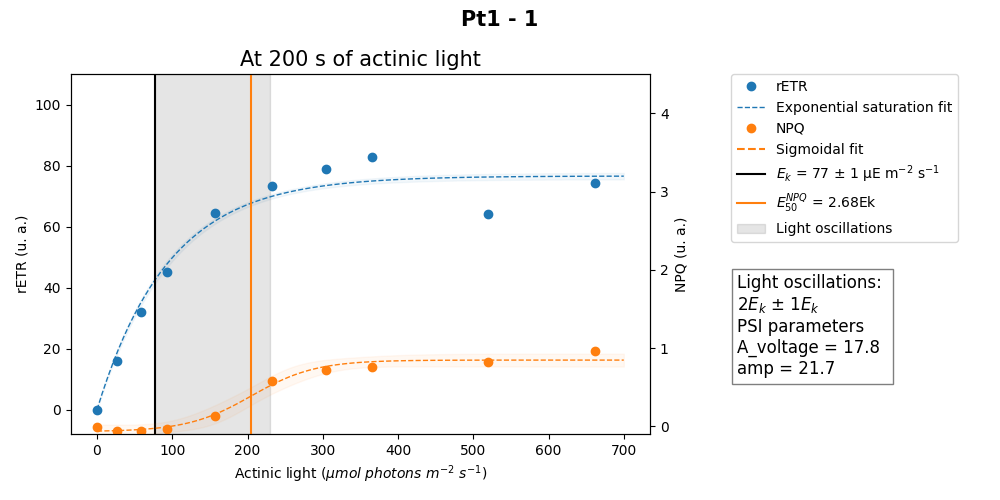

In [18]:
importlib.reload(tools)

sample = condition

offset_Ek = 2
amp_EK = 1

light = params_df.Actinic.tolist()
ETR_matrix = np.asarray(params_df.ETR.tolist())

time_Fmax = 200

fig, ax = plt.subplots(figsize = (10,5))
fig.suptitle(f"{sample}", fontsize = 15, fontweight = 'bold')
ax.set_title(f"At {time_Fmax} s of actinic light", fontsize = 15)


i = times_Fmax.index(time_Fmax + 10)

ETR = ETR_matrix[:,i]
ax.plot(light, ETR, 'o', label = "rETR", color = 'C0')
popt, pcov, xfit, yfit = tools.Ek_fit(light, ETR, 0, 700, 100, p0 = [100, 100])
err = tools.my_err(xfit, popt, pcov, mf.Ek)
ax.fill_between(xfit, yfit - 1.94*err, yfit + 1.94*err, alpha=0.05, color = "C0")
ax.plot(xfit, yfit, '--', linewidth = 1, label = "Exponential saturation fit", color = 'C0')
Ek = popt[0]
Ek_err = np.sqrt(np.diag(pcov))[0]

ax.plot([], [], 'o', label = f"NPQ", color = 'C1')
ax.plot([], [], '--', label = "Sigmoidal fit", color = 'C1')

ax2 = ax.twinx()
ax2.plot(params_df.Actinic, np.asarray(params_df.NPQ.tolist())[:,i], 'o', label = f"NPQ", color = 'C1')
ax2.set_ylabel("NPQ (u. a.)")

popt, pcov, xfit, yfit = tools.sigmoid_fit(light, np.asarray(params_df.NPQ.tolist())[:,i], 0, 700, 100, p0 =  [1, 0.02, 300, 0])
err = tools.my_err(xfit, popt, pcov, mf.sigmoid)
ax2.fill_between(xfit, yfit - 1.94*err, yfit + 1.94*err, alpha=0.05, color = "C1")
ax2.plot(xfit, yfit, '--', linewidth = 1, label = "Fit", color = 'C1')
ax2.axvline(x=popt[2], linewidth=1.5, color = 'C1')


ax.axvline(x=Ek, linewidth=1.5, label = f"$E_k$ = {Ek:.0f} ± {Ek_err:.0f} µE m$^{{-2}}$ s$^{{-1}}$", color = 'k')
ax.set_xlabel("Actinic light ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)")
ax.set_ylabel("rETR (u. a.)")
AL_min = tools.get_AL(offset_Ek*Ek - amp_EK*Ek)
AL_max = tools.get_AL(offset_Ek*Ek + amp_EK*Ek)
AL_amp = AL_max - AL_min

ax.plot([], [], '-', label = "$E_{50}^{NPQ}$ = " + f"{popt[2]/Ek:.2f}Ek", color = 'C1')

ax.text(1.15, 0.3, f"Light oscillations: \n{offset_Ek}$E_k$ ± {amp_EK}$E_k$ \nPSI parameters \nA_voltage = {AL_min:.1f} \namp = {AL_amp:.1f}", fontsize=12, verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

ax.set_ylim(-8, 110)
ax2.set_ylim(-0.1, 4.5)
ylim = ax.get_ylim()
ax.fill_betweenx([ylim[0], ylim[1]], offset_Ek*Ek - amp_EK*Ek, offset_Ek*Ek + amp_EK*Ek, alpha=0.1, color = "k", label = "Light oscillations")
ax.set_ylim(ylim)
ax.legend(bbox_to_anchor=(1.14, 1), loc='upper left', borderaxespad=0.)

fig.tight_layout()
fig.savefig(f"{manip.fig_folder}/ETR_NPQ.png", dpi=300)

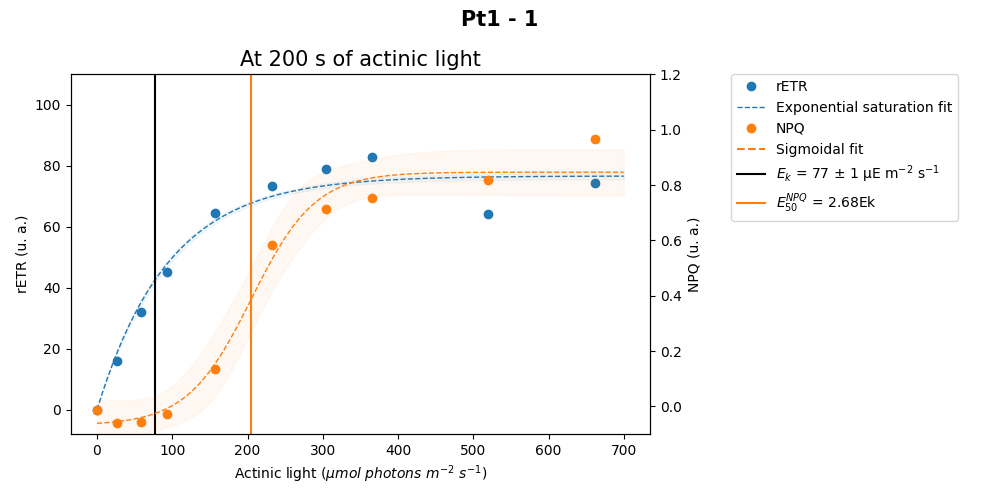

In [19]:
importlib.reload(tools)

sample = condition

offset_Ek = 3.13
amp_EK = 1.5

light = params_df.Actinic.tolist()
ETR_matrix = np.asarray(params_df.ETR.tolist())

time_Fmax = 200

fig, ax = plt.subplots(figsize = (10,5))
fig.suptitle(f"{sample}", fontsize = 15, fontweight = 'bold')
ax.set_title(f"At {time_Fmax} s of actinic light", fontsize = 15)


i = times_Fmax.index(time_Fmax + 10)

ETR = ETR_matrix[:,i]
ax.plot(light, ETR, 'o', label = "rETR", color = 'C0')
popt, pcov, xfit, yfit = tools.Ek_fit(light, ETR, 0, 700, 100, p0 = [100, 100])
err = tools.my_err(xfit, popt, pcov, mf.Ek)
ax.fill_between(xfit, yfit - 1.94*err, yfit + 1.94*err, alpha=0.05, color = "C0")
ax.plot(xfit, yfit, '--', linewidth = 1, label = "Exponential saturation fit", color = 'C0')
Ek = popt[0]
Ek_err = np.sqrt(np.diag(pcov))[0]

ax.plot([], [], 'o', label = f"NPQ", color = 'C1')
ax.plot([], [], '--', label = "Sigmoidal fit", color = 'C1')

ax2 = ax.twinx()
ax2.plot(params_df.Actinic, np.asarray(params_df.NPQ.tolist())[:,i], 'o', label = f"NPQ", color = 'C1')
ax2.set_ylabel("NPQ (u. a.)")

popt, pcov, xfit, yfit = tools.sigmoid_fit(light, np.asarray(params_df.NPQ.tolist())[:,i], 0, 700, 100, p0 =  [1, 0.02, 300, 0])
err = tools.my_err(xfit, popt, pcov, mf.sigmoid)
ax2.fill_between(xfit, yfit - 1.94*err, yfit + 1.94*err, alpha=0.05, color = "C1")
ax2.plot(xfit, yfit, '--', linewidth = 1, label = "Fit", color = 'C1')
ax2.axvline(x=popt[2], linewidth=1.5, color = 'C1')


ax.axvline(x=Ek, linewidth=1.5, label = f"$E_k$ = {Ek:.0f} ± {Ek_err:.0f} µE m$^{{-2}}$ s$^{{-1}}$", color = 'k')
ax.set_xlabel("Actinic light ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)")
ax.set_ylabel("rETR (u. a.)")
AL_min = tools.get_AL(offset_Ek*Ek - amp_EK*Ek)
AL_max = tools.get_AL(offset_Ek*Ek + amp_EK*Ek)
AL_amp = AL_max - AL_min

ax.plot([], [], '-', label = "$E_{50}^{NPQ}$ = " + f"{popt[2]/Ek:.2f}Ek", color = 'C1')

#ax.text(1.15, 0.3, f"Light oscillations: \n{offset_Ek}$E_k$ ± {amp_EK}$E_k$ \nPSI parameters \nA_voltage = {AL_min:.1f} \namp = {AL_amp:.1f}", fontsize=12, verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

ax.set_ylim(-8, 110)
ax2.set_ylim(-0.1, 1.2)
ylim = ax.get_ylim()
#ax.fill_betweenx([ylim[0], ylim[1]], offset_Ek*Ek - amp_EK*Ek, offset_Ek*Ek + amp_EK*Ek, alpha=0.1, color = "k", label = "Light oscillations")
ax.set_ylim(ylim)
ax.legend(bbox_to_anchor=(1.14, 1), loc='upper left', borderaxespad=0.)

fig.tight_layout()
fig.savefig(f"{manip.fig_folder}/ETR_NPQ.png", dpi=300)

In [104]:
from scipy.optimize import curve_fit
def sigmoid_fit(xdata, ydata, start, stop, num, p0 = None):
    def sigmoid(x, A, B, C, D):
        return A / (1 + np.exp(-B * (x - C))) + D

    popt, pcov = curve_fit(sigmoid, xdata, ydata, p0 = p0)
    xfit = np.linspace(start, stop, num)
    yfit = sigmoid(xfit, popt[0], popt[1], popt[2], popt[3])
    return popt, pcov, xfit, yfit

def sigmoid(x, A, B, C, D):
    return A / (1 + np.exp(-B * (x - C))) + D

In [105]:
popt

array([ 8.34236555e-01,  1.24383679e-02,  2.76858480e+02, -6.93981134e-02])

Text(0, 0.5, 'NPQ (u. a.)')

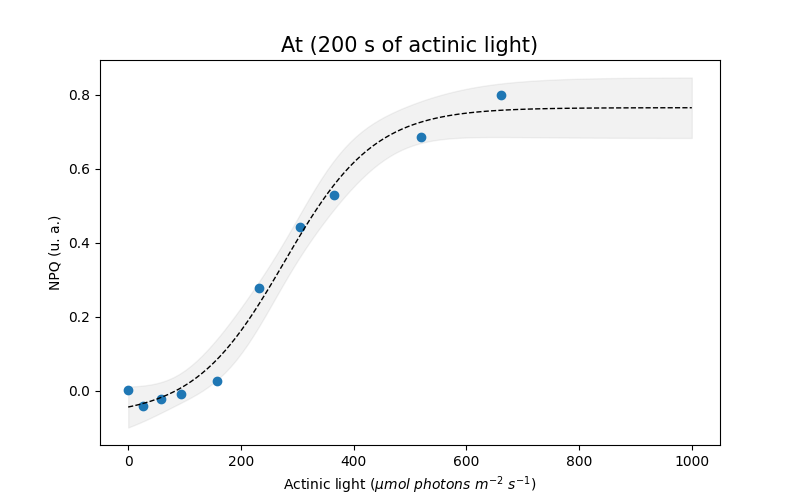

In [106]:
time_Fmax = 200
p0 = [1, 0.02, 300, 0]

fig, ax = plt.subplots(figsize = (8,5))
ax.set_title(f"At ({time_Fmax} s of actinic light)", fontsize = 15)


i = times_Fmax.index(time_Fmax + 10)

light = params_df.Actinic.tolist()
NPQ = np.asarray(params_df.NPQ.tolist())[:,i]
ax.plot(light, NPQ, 'o', label = f"NPQ")

popt, pcov, xfit, yfit = sigmoid_fit(light, NPQ, 0, 1000, 100, p0 = p0)
ax.plot(xfit, yfit, '--', color ="k", linewidth = 1, label = "Fit")
err = tools.my_err(xfit, popt, pcov, sigmoid)
ax.fill_between(xfit, yfit - 1.94*err, yfit + 1.94*err, alpha=0.05, color = "k")


ax.set_xlabel("Actinic light ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)")
ax.set_ylabel("NPQ (u. a.)")


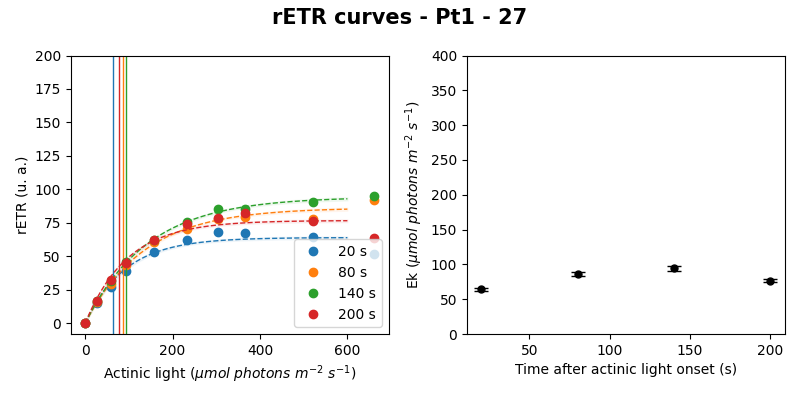

In [107]:

light = params_df.Actinic.tolist()
ETR_matrix = np.asarray(params_df.ETR.tolist())

fig, ax = plt.subplots(1,2, figsize = (8,4))
fig.suptitle(f"rETR curves - {condition}", fontsize = 15, fontweight = 'bold')

Ek = []
Ek_err = []

for i in range(len(times_Fmax)):
    ETR = ETR_matrix[:,i]
    ax[0].plot(light, ETR, 'o', label = f"{times_Fmax[i]-10} s", color = f"C{i}")
    popt, pcov, xfit, yfit = tools.Ek_fit(light, ETR, 0, 600, 100, p0 = [100, 100])
    err = tools.my_err(xfit, popt, pcov, mf.Ek)
    ax[0].fill_between(xfit, yfit - 1.94*err, yfit + 1.94*err, alpha=0.05, color = f"C{i}")
    ax[0].plot(xfit, yfit, '--', color =f"C{i}", linewidth = 1)
    Ek.append(popt[0])
    Ek_err.append(np.sqrt(np.diag(pcov))[1])

    ax[0].axvline(x=Ek[i], color=f"C{i}", linewidth=1)


    
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Actinic light ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)")
ax[0].set_ylabel("rETR (u. a.)")
ax[0].set_ylim(-8, 200)

ax[1].errorbar(np.array(times_Fmax)-10, Ek, yerr = Ek_err, fmt = 'o', color = 'k', capsize = 5, markersize = 5)
ax[1].set_xlabel("Time after actinic light onset (s)")
ax[1].set_ylabel("Ek ($µmol$ $photons$ $m^{-2}$ $s^{-1}$)")
ax[1].set_ylim(0, 400)

fig.tight_layout()
fig.savefig(f"{manip.fig_folder}/ETR.png", dpi=300)